<a href="https://colab.research.google.com/github/radoslaw626/TinyVGG/blob/main/TinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
%cd drive/MyDrive/Git/TinyVGG
!ls

[Errno 2] No such file or directory: 'drive/MyDrive/Git/TinyVGG'
/content/drive/MyDrive/Git/TinyVGG
README.md  TinyVGG.ipynb


In [89]:
import os

if not os.path.exists('scripts'):
    os.makedirs('scripts')

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [91]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path}  directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
downloading pizza, steak, sushi data
unzipping


In [92]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [93]:
walk_through_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [94]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [95]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

print(image_class)

img = Image.open(random_image_path)

print(f"random image path: {random_image_path}")
img, img.size

steak
random image path: data/pizza_steak_sushi/train/steak/482022.jpg


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>, (512, 512))

(512, 512, 3)


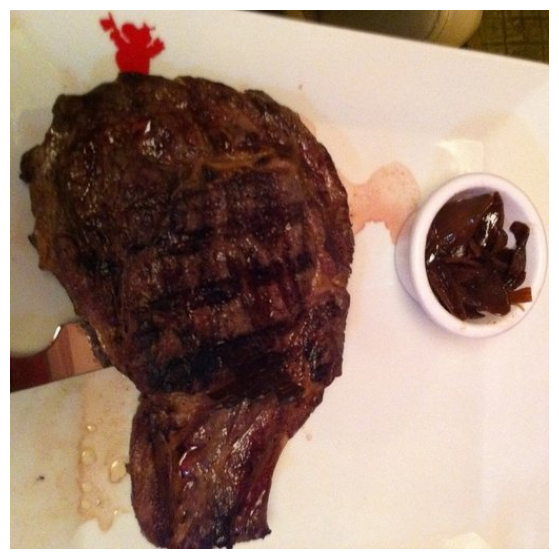

In [96]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.axis(False)
print(img_as_array.shape)
plt.imshow(img_as_array)

In [97]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [98]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [99]:
data_transform(img).shape

torch.Size([3, 64, 64])

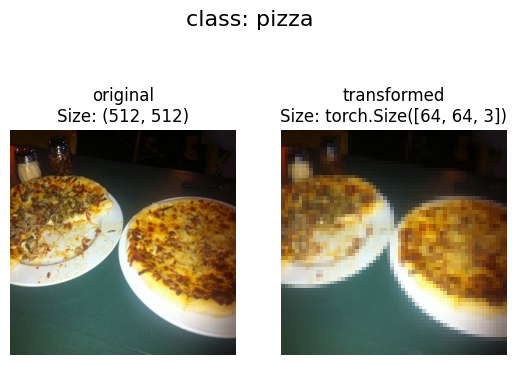

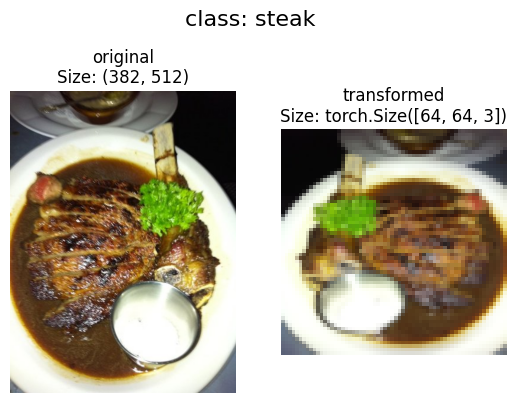

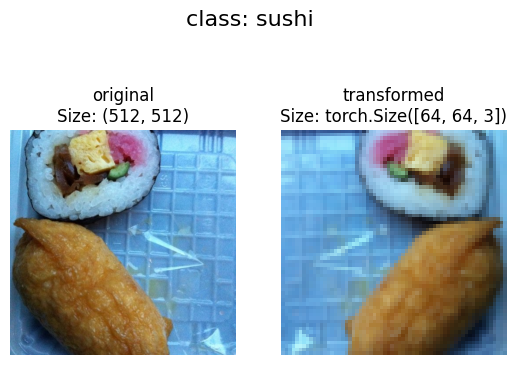

In [100]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

In [101]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)


train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [102]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [103]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [104]:
len(train_data), len(test_data)

(225, 75)

In [105]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [106]:
img, label = train_data[0][0], train_data[0][1]
print(f"image tensor: {img}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"image datatype: {type(label)}")

image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

original shape: torch.Size([3, 64, 64])
permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

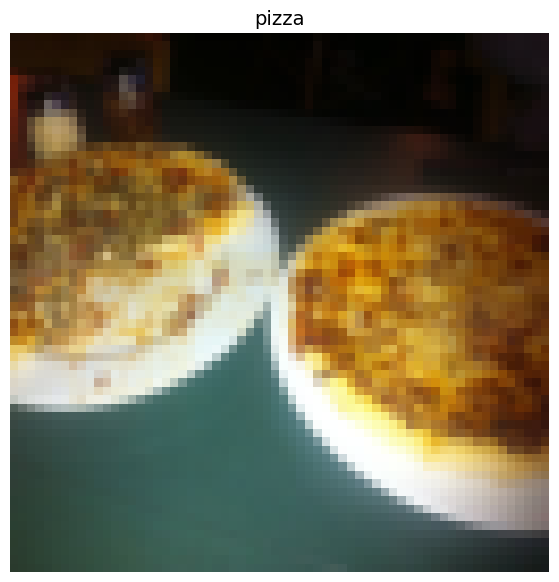

In [107]:
img_permute = img.permute(1, 2, 0)

print(f"original shape: {img.shape}")
print(f"permute shape: {img_permute.shape}")


plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [108]:
import os
os.cpu_count()

2

In [109]:
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x793f672b7df0>,
 <torch.utils.data.dataloader.DataLoader at 0x793f672b7a60>)

In [110]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [111]:
img, label = next(iter(train_dataloader))

print(f"image shape: {img.shape}")
print(f"label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


image shape: torch.Size([1, 3, 64, 64])
label shape: torch.Size([1])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [112]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [113]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [114]:
target_directory = train_dir
print(f"target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [115]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"could not find any classes in {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [116]:
find_classes(str(target_directory))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [117]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [118]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [119]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x793f6f9da470>,
 <__main__.ImageFolderCustom at 0x793f7c821c60>)

In [120]:
len(train_data), len(train_data_custom)

(225, 225)

In [121]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [122]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [123]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [124]:
def display_random_images (dataset: torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n: int = 10,
                           display_shape: bool = True,
                           seed: int = None):
  if n > 10:
    n=10
    display_shape = False
    print(f"for display purposes n shouldnt be larger than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

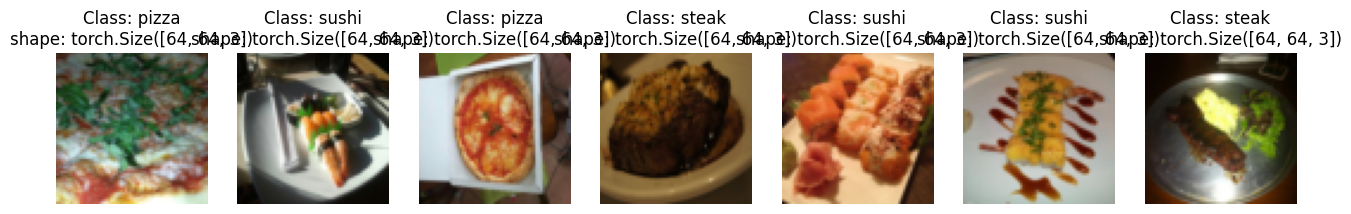

In [125]:
display_random_images(train_data,
                      n=7,
                      classes=class_names,
                      seed=None)

In [126]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x793f671201c0>,
 <torch.utils.data.dataloader.DataLoader at 0x793f671200a0>)

In [127]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [128]:
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [129]:
image_path

PosixPath('data/pizza_steak_sushi')

In [130]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')]

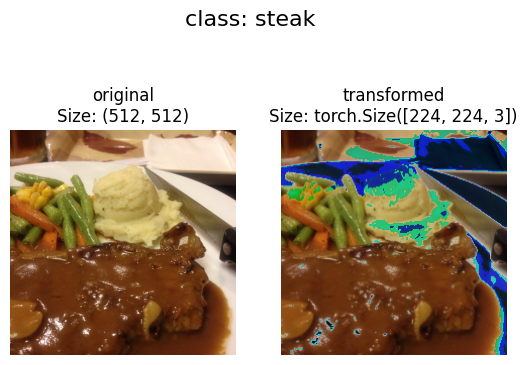

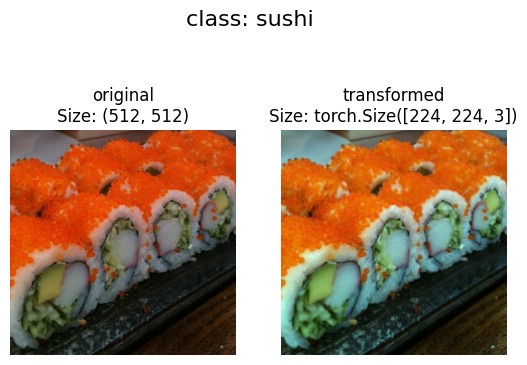

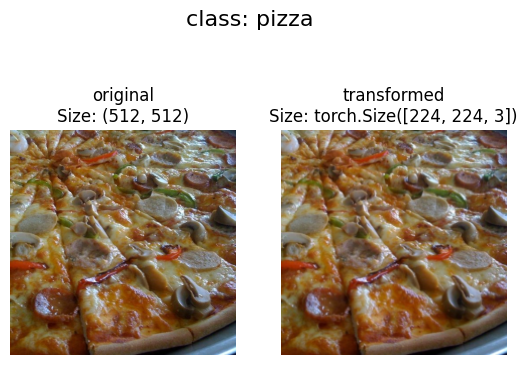

In [131]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

In [132]:
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

In [133]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [134]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [135]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [136]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [137]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [138]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()
  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [139]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [140]:
NUM_EPOCHS = 50

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0975 | Train acc: 0.2734 | Test loss: 1.1201 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0988 | Train acc: 0.3047 | Test loss: 1.1209 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0942 | Train acc: 0.3047 | Test loss: 1.1357 | Test acc: 0.2812
Epoch: 3 | Train loss: 1.1084 | Train acc: 0.4570 | Test loss: 1.1270 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0971 | Train acc: 0.3867 | Test loss: 1.0888 | Test acc: 0.3011
Epoch: 5 | Train loss: 1.0688 | Train acc: 0.4023 | Test loss: 1.0679 | Test acc: 0.2708
Epoch: 6 | Train loss: 1.0898 | Train acc: 0.4141 | Test loss: 1.0384 | Test acc: 0.5227
Epoch: 7 | Train loss: 1.0258 | Train acc: 0.4727 | Test loss: 1.1045 | Test acc: 0.2500
Epoch: 8 | Train loss: 0.9997 | Train acc: 0.3867 | Test loss: 1.0310 | Test acc: 0.5341
Epoch: 9 | Train loss: 0.9767 | Train acc: 0.4492 | Test loss: 0.9502 | Test acc: 0.5758
Epoch: 10 | Train loss: 0.9838 | Train acc: 0.5078 | Test loss: 1.0182 | Test acc: 0.3617
Epoch: 11 | Train lo

In [141]:
model_0_results

{'train_loss': [1.0975240468978882,
  1.098814070224762,
  1.094204604625702,
  1.1084026098251343,
  1.0970831364393234,
  1.0687914341688156,
  1.0897795855998993,
  1.0258198082447052,
  0.9996676668524742,
  0.9767495691776276,
  0.9838231801986694,
  0.7752283196896315,
  0.8832647651433945,
  0.8073671758174896,
  0.7598845735192299,
  0.7114346902817488,
  0.8558769449591637,
  0.8902293220162392,
  0.7989142313599586,
  0.7361947223544121,
  0.7458847612142563,
  0.8161767795681953,
  0.7255919501185417,
  0.9625382497906685,
  0.7988144159317017,
  0.7778937965631485,
  0.7542172595858574,
  0.6608916707336903,
  0.743938222527504,
  0.6357220038771629,
  0.5791270025074482,
  0.5400176951661706,
  0.5170921308454126,
  0.7974488288164139,
  0.5166902085766196,
  0.4905728567391634,
  0.5533735193312168,
  0.670969121158123,
  0.48215969838202,
  0.5675274655222893,
  0.43904887803364545,
  0.4649968035519123,
  0.5735116302967072,
  0.5170278437435627,
  0.5502931773662567,
 

In [142]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [143]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

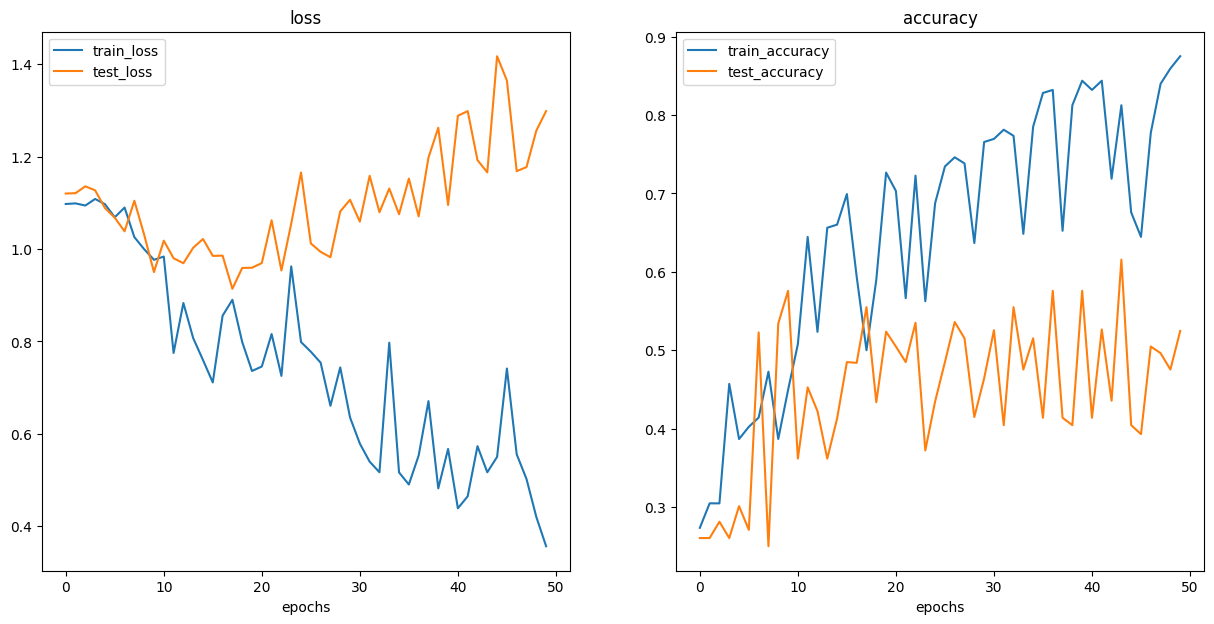

In [144]:
plot_loss_curves(model_0_results)


In [145]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

In [146]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [147]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [148]:
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [149]:
NUM_EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1227 | Train acc: 0.2891 | Test loss: 1.1174 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0997 | Train acc: 0.3086 | Test loss: 1.0782 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.1114 | Train acc: 0.3047 | Test loss: 1.0840 | Test acc: 0.4129
Epoch: 3 | Train loss: 1.1005 | Train acc: 0.3398 | Test loss: 1.0953 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0960 | Train acc: 0.2930 | Test loss: 1.0945 | Test acc: 0.2604
Epoch: 5 | Train loss: 1.0489 | Train acc: 0.4297 | Test loss: 1.0865 | Test acc: 0.2604
Epoch: 6 | Train loss: 1.0761 | Train acc: 0.4297 | Test loss: 1.1100 | Test acc: 0.2604
Epoch: 7 | Train loss: 1.0923 | Train acc: 0.3125 | Test loss: 1.0882 | Test acc: 0.2708
Epoch: 8 | Train loss: 1.0877 | Train acc: 0.3672 | Test loss: 1.0996 | Test acc: 0.2812
Epoch: 9 | Train loss: 1.0385 | Train acc: 0.5156 | Test loss: 1.0920 | Test acc: 0.2604
Epoch: 10 | Train loss: 1.0370 | Train acc: 0.4297 | Test loss: 1.1346 | Test acc: 0.2604
Epoch: 11 | Train lo

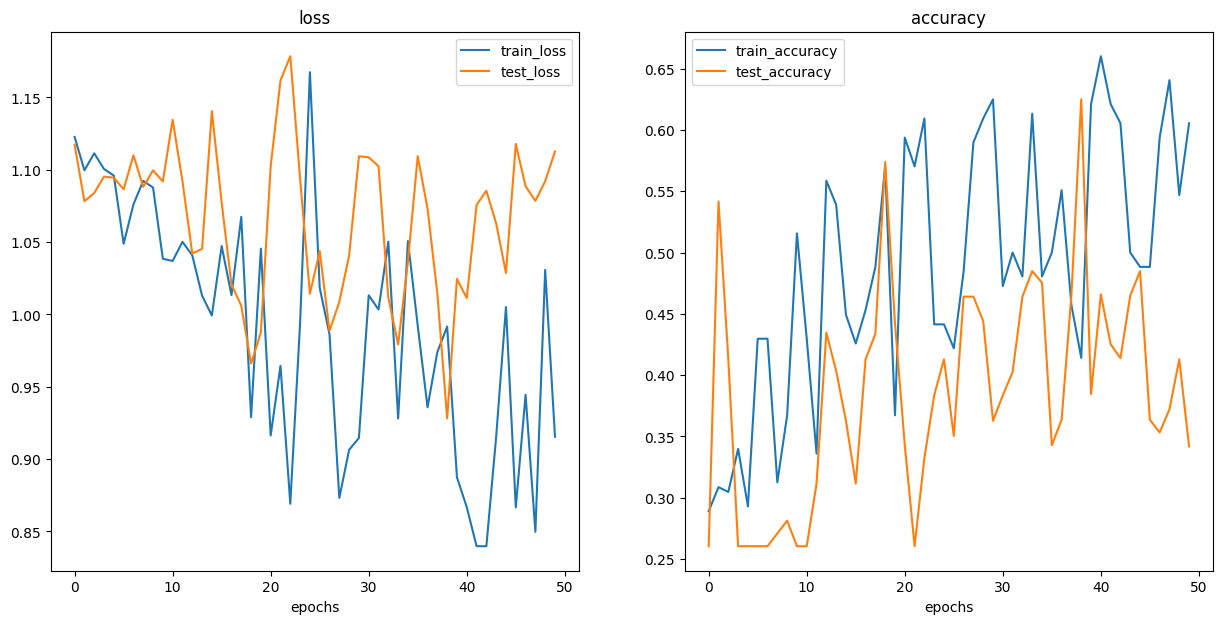

In [150]:
plot_loss_curves(model_1_results)

In [151]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.097524,0.273438,1.120123,0.260417
1,1.098814,0.304688,1.120946,0.260417
2,1.094205,0.304688,1.135740,0.281250
3,1.108403,0.457031,1.127041,0.260417
4,1.097083,0.386719,1.088785,0.301136
5,1.068791,0.402344,1.067909,0.270833
6,1.089780,0.414062,1.038368,0.522727
7,1.025820,0.472656,1.104494,0.250000
8,0.999668,0.386719,1.031027,0.534091
9,0.976750,0.449219,0.950176,0.575758


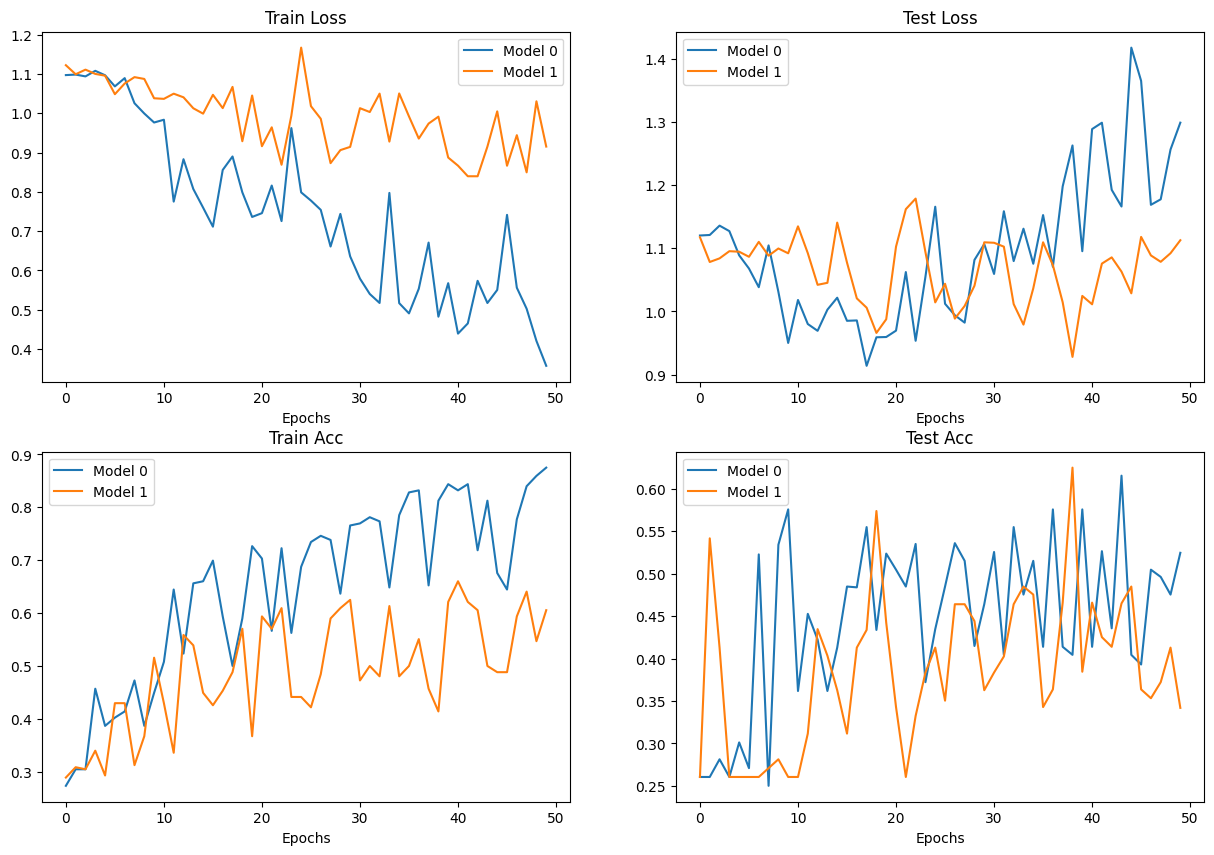

In [152]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

In [153]:
import requests

custom_image_path = data_path / "pizza.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://t4.ftcdn.net/jpg/06/53/54/87/360_F_653548703_MwhAw9fCtvFSaroiErTxRM5j3LogV55c.jpg")
    print(f"downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

downloading data/pizza.jpg


In [154]:
custom_image_path

PosixPath('data/pizza.jpg')

In [155]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[1, 1, 1,  ..., 6, 6, 7],
         [1, 1, 1,  ..., 6, 6, 7],
         [0, 0, 0,  ..., 6, 6, 7],
         ...,
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 5, 5, 5],
         [0, 0, 0,  ..., 5, 5, 5]],

        [[0, 0, 0,  ..., 4, 4, 5],
         [0, 0, 0,  ..., 4, 4, 5],
         [0, 0, 0,  ..., 4, 4, 5],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 5, 5, 6],
         [0, 0, 0,  ..., 5, 5, 6],
         [0, 0, 0,  ..., 5, 5, 6],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 360, 540])
Custom image datatype: torch.uint8


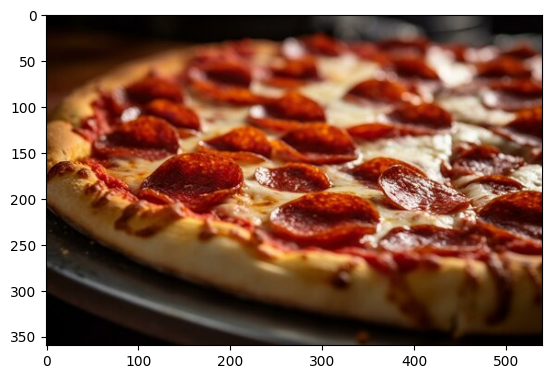

In [156]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [157]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0275],
         [0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0275],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.

In [158]:
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"original shape: {custom_image.shape}")
print(f"transformed shape: {custom_image_transformed.shape}")

original shape: torch.Size([3, 360, 540])
transformed shape: torch.Size([3, 64, 64])


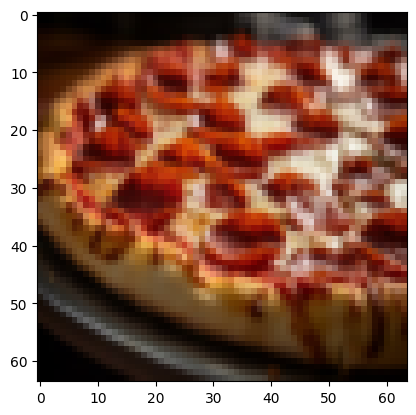

In [159]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [160]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [161]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[-0.1251, -0.7155, -0.2248]])

In [162]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4066, 0.2253, 0.3680]])

In [163]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [164]:
class_names[custom_image_pred_label]

'pizza'

In [165]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255.

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

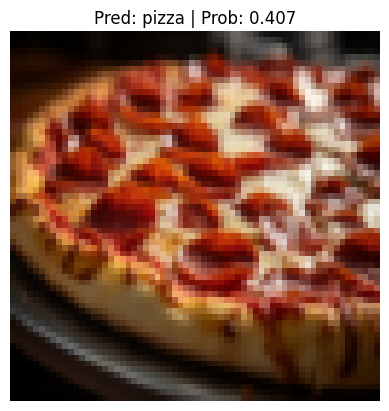

In [166]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)